### Example case study: Florida May 20

According to [CNN](https://www.cnn.com/interactive/2020/us/states-reopen-coronavirus-trnd/) Florida started reopening businesses on May 4 (16 days ago). Let's see if already there is evidence for higher transmission rate.

First open the GUI to view the data and model

In [2]:
from ipypm import ipypm

In [3]:
my_ipypm = ipypm.ipypm()
my_ipypm.get_display()

The model fl_2_1_0520.pypm contains the best fits for the transmissions. The best fit time for the third transition is day 61 (around May 1).

For the ref_2_1 model, to convert from transmission rate to Reproduction Number, multiply by 6.58. The scaling factor is found by adjusting alpha until steady population sizes are found (R=1).

Show the values for the reproduction numbers:

In [4]:
my_model = my_ipypm.model
print('R_0 = {0:0.2f}'.format(6.58*my_model.parameters['alpha_0'].get_value()))
for i in range(3):
    j=i+1
    if my_model.transitions['trans_rate_'+str(j)].enabled:
        print('Day_'+str(j)+':',str(my_model.parameters['trans_rate_'+str(j)+'_time'].get_value()))
        print('R_{0:d} = {1:0.2f}'.format(j,6.58*my_model.parameters['alpha_'+str(j)].get_value()))

R_0 = 3.13
Day_1: 27
R_1 = 1.02
Day_2: 35
R_2 = 0.86
Day_3: 61
R_3 = 1.07


In [5]:
import pypmca.tools.table as ptt
print(ptt.variable_parameter_table(my_model,width=110))

Parameter   Description            min   max    prior     prior_mean   prior_w     mcmc_step   Init     Value 
alpha_0     initial transmission   0     2      uniform   1.000e+00    1.000e+00   None        0.475    0.475 
            rate                                                                                              
--------------------------------------------------------------------------------------------------------------
alpha_1     transmission rate      0     2      uniform   1.000e+00    1.000e+00   None        0.154    0.154 
            after 1st transition                                                                              
--------------------------------------------------------------------------------------------------------------
alpha_2     transmission rate      0     2      uniform   1.000e+00    1.000e+00   None        0.131    0.131 
            after 2nd transition                                                                              
-

## Uncertainty

One way to report uncertainty is the standard deviation of the estimator. Let's do 50 simulations and look at the standard deviation of the estimates

In [12]:
import copy
from pypmca.analysis.Optimizer import Optimizer
ref_model = copy.deepcopy(my_ipypm.model)
opt_model = copy.deepcopy(my_ipypm.model)
sim_model = copy.deepcopy(my_ipypm.model)
sim_model.reset()
sim_model.generate_data(81)
my_optimizer = Optimizer(opt_model,'total reported',sim_model.populations['reported'].history,[28,81])
popt, pcov = my_optimizer.fit()
print (popt)

[47.80854013  0.47447547  0.15506369  0.12981412  0.15535783]


In [7]:
import numpy as np
import matplotlib.pyplot as plt

alphas = [[],[],[],[]]
for i in range(50):
    my_optimizer.reset_variables()
    sim_model.reset()
    sim_model.generate_data(81)
    my_optimizer.data = sim_model.populations['reported'].history
    popt, pcov = my_optimizer.fit()
    for j in range(4):
        alphas[j].append(popt[j+1])

for i in range(4):
    print(np.mean(alphas[i]),np.std(alphas[i]))

0.47502630813191254 0.006541582871193975
0.15441481673804724 0.003482734838837981
0.1309574215280362 0.0013133193334604208
0.16318711317733986 0.0026375494411537497


The fits appear to be unbiased. 

Now check how much the variance of the estimators increase when including additional sources of noise:

Ref model 2.1 includes two new features:
* reporting noise (to account for large day to day fluctuations)
* negative binomial distribution for infection generation (common in the discipline)


Let's look at the daily data, where the reporting noise is very apparent

In [17]:
def delta(cumul):
    diff = []
    for i in range(1, len(cumul)):
        diff.append(cumul[i] - cumul[i - 1])
    return diff

fl_data = my_ipypm.optimizer.data
sim_data = sim_model.populations['reported'].history
ref_data = ref_model.populations['reported'].history

# derive daily data from the cumulative
fl_daily = delta(fl_data)
sim_daily = delta(sim_data)
ref_daily = delta(ref_data)

t = range(len(fl_daily[:80]))

# Reporting noise

The default has the report_noise parameter = 1 (no noise)
Clearly not representative of the data

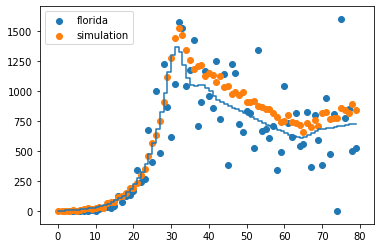

In [19]:
sim_model.parameters['report_noise'].set_value(1.)
sim_model.reset()
sim_model.generate_data(81)
sim_data = sim_model.populations['reported'].history
sim_daily = delta(sim_data)

plt.step(t,ref_daily[:80])
plt.scatter(t,fl_daily[:80], label='florida')
plt.scatter(t,sim_daily[:80], label='simulation')
plt.legend()
plt.show()

# Change the report noise parameter to 0.3

This means that each day, a fraction of that day's positive cases (random: uniform between 0.3 and 1) are reported along with the previous day's positives that weren't reported that day.

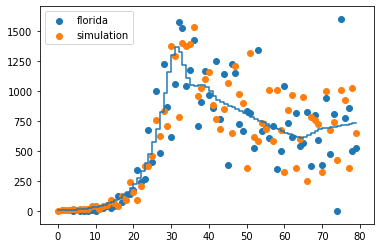

In [20]:
sim_model.parameters['report_noise'].set_value(0.3)
sim_model.reset()
sim_model.generate_data(81)
sim_data = sim_model.populations['reported'].history
sim_daily = delta(sim_data)

plt.step(t,ref_daily[:80])
plt.scatter(t,fl_daily[:80], label='florida')
plt.scatter(t,sim_daily[:80], label='simulation')
plt.legend()
plt.show()

In [21]:
# re-evaluate the standard deviations of the estimators

alphas = [[],[],[],[]]
for i in range(50):
    my_optimizer.reset_variables()
    sim_model.reset()
    sim_model.generate_data(81)
    my_optimizer.data = sim_model.populations['reported'].history
    popt, pcov = my_optimizer.fit()
    for j in range(4):
        alphas[j].append(popt[j+1])

for i in range(4):
    print(np.mean(alphas[i]),np.std(alphas[i]))

0.4832533327728176 0.014478672121167276
0.16149321757607374 0.005886275611657458
0.13020677931197328 0.0018020069669639493
0.16295647045413808 0.004221036043723268


So the standard deviation increases somewhat by including the reporting noise


## Negative binomial parameter in the infection cycle

It seems common to not treat each infection as independent (ie. Poisson). Instead a negative binomial distribution is
used. In the scipy.stats.nbinom function, there is an additional parameter, p, that scales the variance. With p=0.1,
the variance is 10 times larger. Cannot rule that value out. Not sure what value to use though!

Produce a plot showing difference between data and reference model.

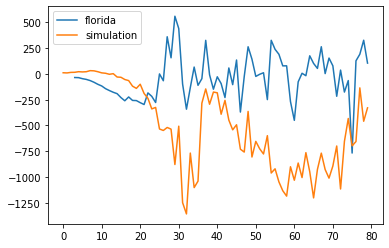

In [22]:
sim_model.parameters['neg_binom_p'].set_value(0.1)
sim_model.reset()
sim_model.generate_data(81)
sim_data = np.array(sim_model.populations['reported'].history)*1.
sim_data *= ref_data[80]/sim_data[80]

xdata = range(len(ref_data[:80]))
plt.plot(xdata,np.array(fl_data[:80])-np.array(ref_data[:80]),label='florida')
plt.plot(xdata,np.array(sim_data[:80])-np.array(ref_data[:80]),label='simulation')
plt.legend()
plt.show()

In [23]:
alphas = [[],[],[],[]]
for i in range(50):
    my_optimizer.reset_variables()
    sim_model.reset()
    sim_model.generate_data(81)
    my_optimizer.data = sim_model.populations['reported'].history
    popt, pcov = my_optimizer.fit()
    for j in range(4):
        alphas[j].append(popt[j+1])

for i in range(4):
    print(np.mean(alphas[i]),np.std(alphas[i]))

0.4846831052094269 0.01783731113696524
0.16040763201312228 0.006889137074102179
0.1307820818849589 0.002927635832220889
0.1615382343699273 0.005749009493858253
